In [24]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
# Load daily dataset
df_daily = pd.read_csv("daily_energy_data.csv", parse_dates=["DateTime"])

# Rename columns for Prophet
df_prophet = df_daily.rename(columns={"DateTime": "ds", "Total_Daily_Consumption": "y"})

print(df_prophet.head())  # Verify the structure


          ds        y
0 2012-05-23  151.445
1 2012-05-24  318.207
2 2012-05-25  339.757
3 2012-05-26  327.922
4 2012-05-27  330.343


In [40]:
# Initialize Prophet model
model = Prophet()

# Fit the model on the data
model.fit(df_prophet)





10:25:24 - cmdstanpy - INFO - Chain [1] start processing
10:25:24 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Create future dataframe for prediction
future = model.make_future_dataframe(periods=90)  # Forecast next 90 days

# Make predictions
forecast = model.predict(future)


# Show forecasted data
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


            ds        yhat  yhat_lower  yhat_upper
732 2014-05-25  332.898934  292.197338  377.205919
733 2014-05-26  329.600385  287.424793  373.829036
734 2014-05-27  314.667062  271.623510  360.951274
735 2014-05-28  314.140545  270.886174  355.051069
736 2014-05-29  314.740221  275.006984  360.243832


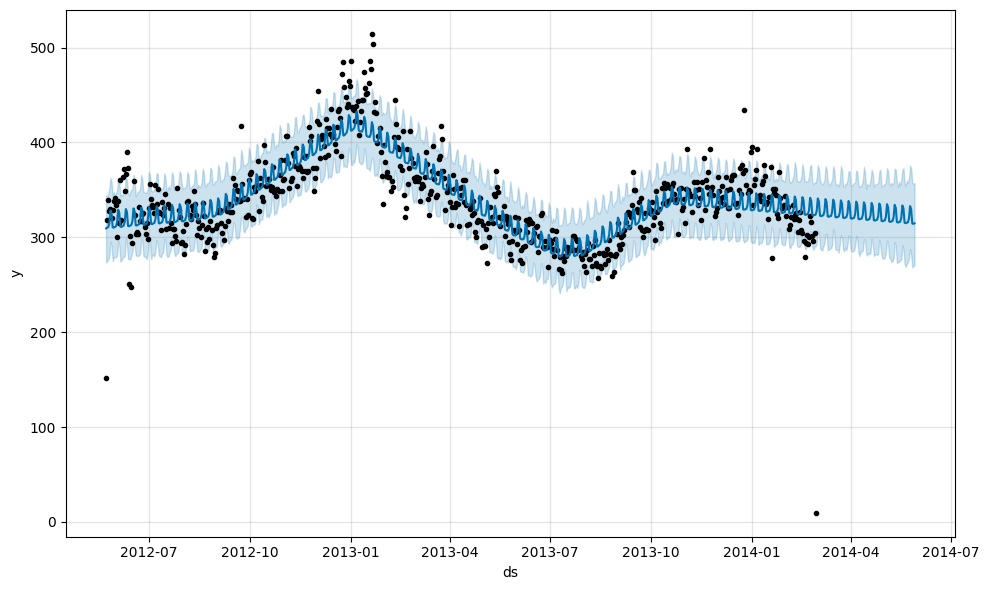

In [28]:
# Plot the forecast
fig = model.plot(forecast)
plt.show()


10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:55 - cmdstanpy - INFO - Chain [1] done processing


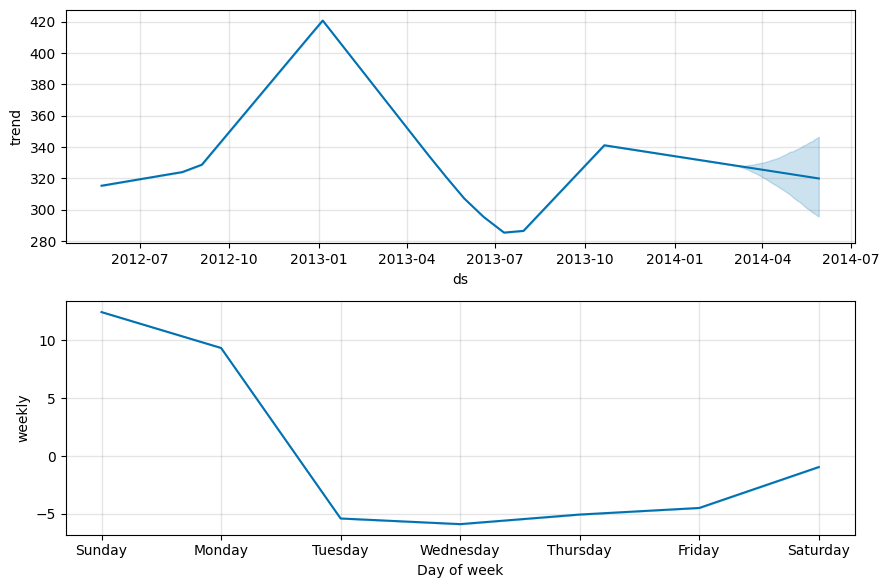

In [43]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)  # Predict next 30 days
forecast_prophet = model.predict(future) 
fig2 = model.plot_components(forecast)
plt.show()


ARIMA (AutoRegressive Integrated Moving Average)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


In [32]:
# Load daily dataset
df_daily = pd.read_csv("daily_energy_data.csv", parse_dates=["DateTime"], index_col="DateTime")

# Perform ADF test
result = adfuller(df_daily["Total_Daily_Consumption"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -0.5425061882114046
p-value: 0.8834514282836677


In [33]:
df_daily["Consumption_Diff"] = df_daily["Total_Daily_Consumption"].diff().dropna()
result = adfuller(df_daily["Consumption_Diff"].dropna())
print("New ADF Statistic:", result[0])
print("New p-value:", result[1])


New ADF Statistic: -11.51000874307917
New p-value: 4.282596259787657e-21


In [37]:
# Import ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model (p=1, d=1, q=1 as a starting point)
model = ARIMA(df_daily["Total_Daily_Consumption"], order=(1,1,1))
model_fit = model.fit()

forecast_arima = model_fit.forecast(steps=30)


# Print model summary
print(model_fit.summary())


                                  SARIMAX Results                                  
Dep. Variable:     Total_Daily_Consumption   No. Observations:                  647
Model:                      ARIMA(1, 1, 1)   Log Likelihood               -2969.638
Date:                     Thu, 13 Mar 2025   AIC                           5945.276
Time:                             10:24:13   BIC                           5958.689
Sample:                         05-23-2012   HQIC                          5950.480
                              - 02-28-2014                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3555      0.057      6.283      0.000       0.245       0.466
ma.L1         -0.8253      0.035    -23.517      0.000      -0.894      -0.757
sigma2      

/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


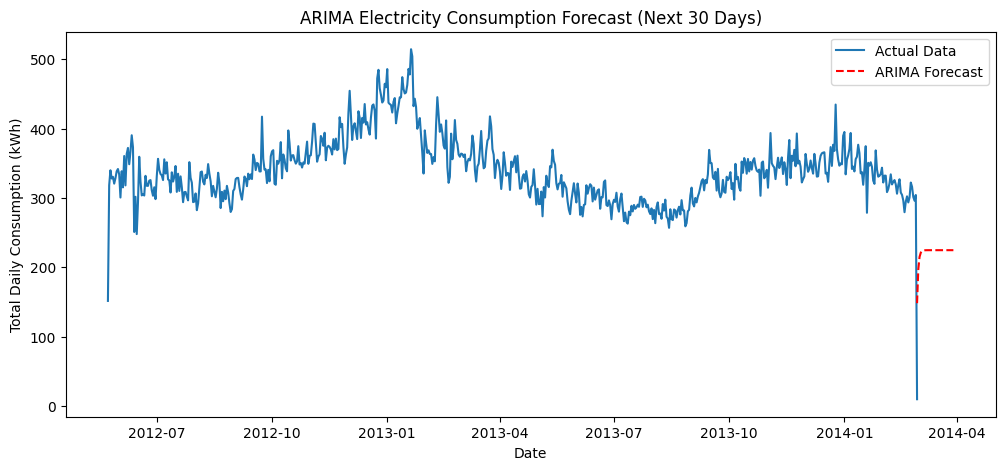

In [35]:
forecast_steps = 30  # Predict next 30 days
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 5))
plt.plot(df_daily.index, df_daily["Total_Daily_Consumption"], label="Actual Data")
plt.plot(pd.date_range(df_daily.index[-1], periods=forecast_steps, freq="D"),
         forecast, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.title("ARIMA Electricity Consumption Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Total Daily Consumption (kWh)")
plt.legend()
plt.show()


MODEL EVALUATION

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define actual vs. predicted values
actual = df_daily["Total_Daily_Consumption"][-30:]  # Last 30 days
predicted_arima = forecast_arima  # Replace with actual ARIMA predictions
predicted_prophet = forecast_prophet["yhat"][-30:].values  # Prophet's last 30 predictions

# Calculate evaluation metrics
def evaluate_model(actual, predicted, model_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

evaluate_model(actual, predicted_arima, "ARIMA")
evaluate_model(actual, predicted_prophet, "Prophet")


ARIMA - RMSE: 102.58, MAE: 97.23
Prophet - RMSE: 71.15, MAE: 59.03


**Lower RMSE & MAE = Better Performance**
  - **Prophet performed better** with **RMSE: 71.15** and **MAE: 59.03** compared to ARIMA.
  - Lower error means Prophet's forecasts are **closer to actual values**.

- **Prophet is a better choice for energy forecasting**
  - Captures **trends and seasonality** effectively, which is crucial for electricity consumption data.


In [47]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np

def tune_prophet(changepoint_prior, fourier_order):
    model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=False,changepoint_prior_scale=changepoint_prior)

    model.add_seasonality(name="yearly",period=365.25,fourier_order=fourier_order)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    actual = df_prophet["y"][-30:]
    predicted = forecast["yhat"][-30:].values
    rmse = np.sqrt(mean_squared_error(actual,predicted))

    print(f"changepoint Scale - {changepoint_prior}, Fourier order- {fourier_order} - RMSE:{rmse:.2f}")
    return rmse, forecast

In [48]:
#test

changepoints = [0.001, 0.01, 0.05, 0.1, 0.5]  # Lower = less flexible, Higher = more flexible
fourier_orders = [5, 10, 20]  # Lower = smoother, Higher = more detailed

best_rmse = float("inf")
best_forecast = None
best_params = None

# Try all combinations
for cp in changepoints:
    for fo in fourier_orders:
        rmse, forecast = tune_prophet(cp, fo)
        if rmse < best_rmse:
            best_rmse = rmse
            best_forecast = forecast
            best_params = (cp, fo)

print(f"✅ Best Settings → Changepoint: {best_params[0]}, Fourier Order: {best_params[1]}, RMSE: {best_rmse:.2f}")

11:00:17 - cmdstanpy - INFO - Chain [1] start processing
11:00:17 - cmdstanpy - INFO - Chain [1] done processing
11:00:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:00:17 - cmdstanpy - INFO - Chain [1] start processing
11:00:18 - cmdstanpy - INFO - Chain [1] done processing
11:00:18 - cmdstanpy - INFO - Chain [1] start processing
11:00:18 - cmdstanpy - INFO - Chain [1] done processing
11:00:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:00:18 - cmdstanpy - INFO - Chain [1] start processing


changepoint Scale - 0.001, Fourier order- 5 - RMSE:62.16


11:00:19 - cmdstanpy - INFO - Chain [1] done processing
11:00:19 - cmdstanpy - INFO - Chain [1] start processing
11:00:19 - cmdstanpy - INFO - Chain [1] done processing
11:00:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:00:19 - cmdstanpy - INFO - Chain [1] start processing


changepoint Scale - 0.001, Fourier order- 10 - RMSE:62.16


11:00:20 - cmdstanpy - INFO - Chain [1] done processing
11:00:20 - cmdstanpy - INFO - Chain [1] start processing
11:00:20 - cmdstanpy - INFO - Chain [1] done processing
11:00:20 - cmdstanpy - INFO - Chain [1] start processing
11:00:20 - cmdstanpy - INFO - Chain [1] done processing
11:00:20 - cmdstanpy - INFO - Chain [1] start processing


changepoint Scale - 0.001, Fourier order- 20 - RMSE:62.16
changepoint Scale - 0.01, Fourier order- 5 - RMSE:60.92
changepoint Scale - 0.01, Fourier order- 10 - RMSE:60.92


11:00:20 - cmdstanpy - INFO - Chain [1] done processing
11:00:20 - cmdstanpy - INFO - Chain [1] start processing
11:00:20 - cmdstanpy - INFO - Chain [1] done processing
11:00:20 - cmdstanpy - INFO - Chain [1] start processing
11:00:20 - cmdstanpy - INFO - Chain [1] done processing


changepoint Scale - 0.01, Fourier order- 20 - RMSE:60.92
changepoint Scale - 0.05, Fourier order- 5 - RMSE:71.15


11:00:20 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing
11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing


changepoint Scale - 0.05, Fourier order- 10 - RMSE:71.15
changepoint Scale - 0.05, Fourier order- 20 - RMSE:71.15


11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing
11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing


changepoint Scale - 0.1, Fourier order- 5 - RMSE:73.56
changepoint Scale - 0.1, Fourier order- 10 - RMSE:73.56


11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing
11:00:21 - cmdstanpy - INFO - Chain [1] start processing


changepoint Scale - 0.1, Fourier order- 20 - RMSE:73.56
changepoint Scale - 0.5, Fourier order- 5 - RMSE:69.05


11:00:21 - cmdstanpy - INFO - Chain [1] done processing
11:00:21 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing


changepoint Scale - 0.5, Fourier order- 10 - RMSE:69.05
changepoint Scale - 0.5, Fourier order- 20 - RMSE:69.05
✅ Best Settings → Changepoint: 0.01, Fourier Order: 5, RMSE: 60.92


## ✅ Best Settings Identified:

- **Changepoint Scale**: `0.01`
- **Fourier Order**: `5`
- **RMSE**: **60.92** (Lowest RMSE)

### 📌 Interpretation:
- **Smaller changepoints** → Helps avoid abrupt changes, making the model more stable.
- **Moderate Fourier order** → Captures seasonal variations efficiently.


In [49]:
#new model

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.01
)

model.add_seasonality(name="monthly", period=30.5, fourier_order=5)


12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing


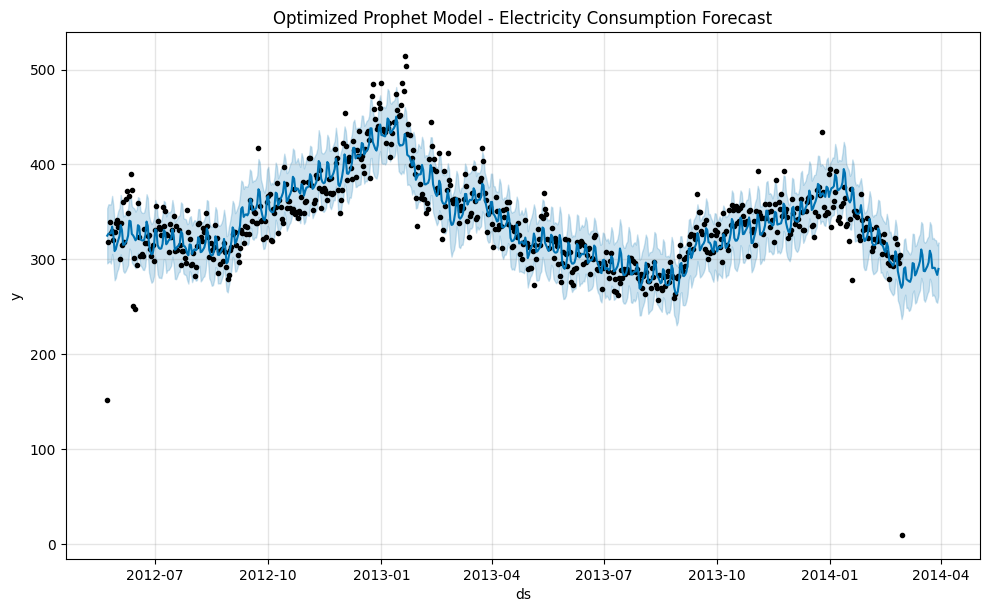

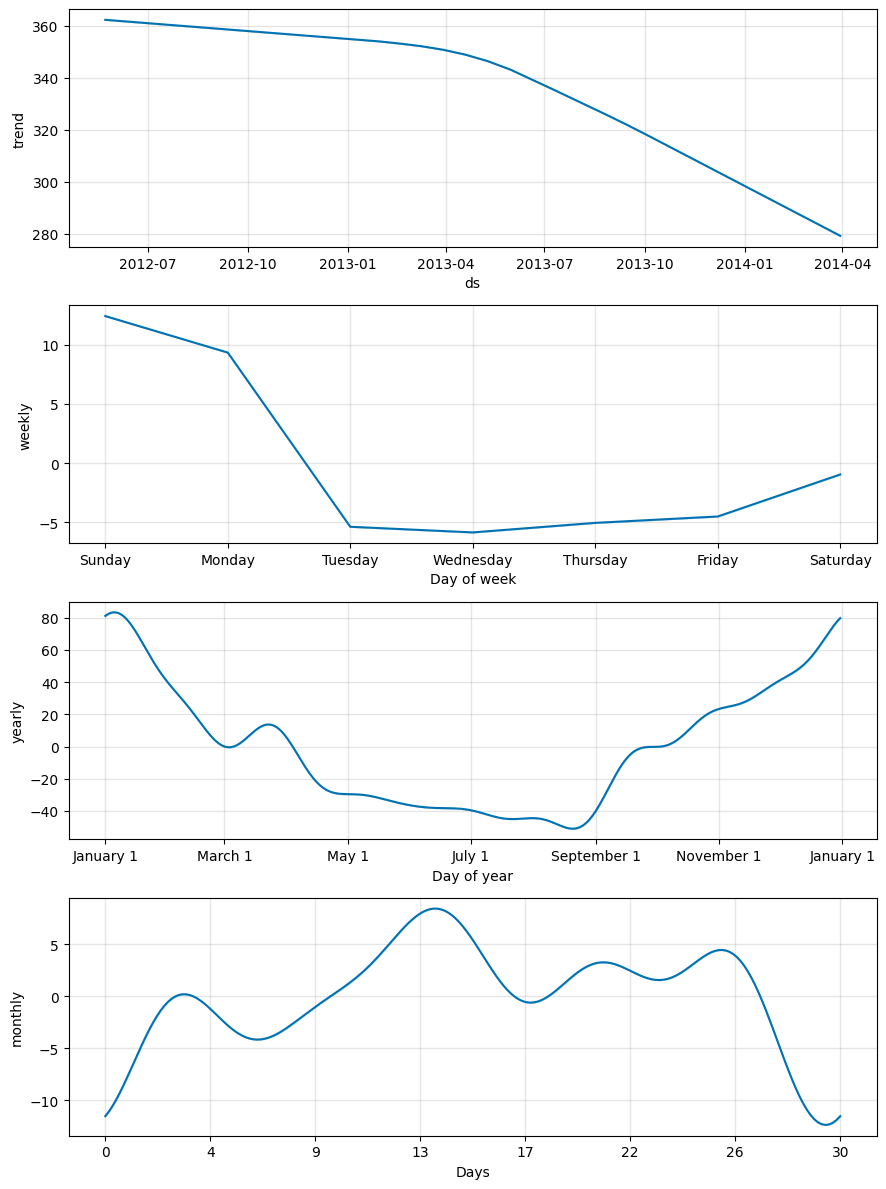

In [50]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Load dataset
df_daily = pd.read_csv("daily_energy_data.csv", parse_dates=["DateTime"], index_col="DateTime")

# Prepare data for Prophet
df_prophet = df_daily.reset_index()[["DateTime", "Total_Daily_Consumption"]]
df_prophet.columns = ["ds", "y"]  # Prophet requires "ds" for date and "y" for target variable

# Define optimized Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.01  # Optimized changepoint scale
)

# Add custom monthly seasonality
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)

# Train the model
model.fit(df_prophet)

# Generate future dataframe for prediction (next 30 days)
future = model.make_future_dataframe(periods=30, freq="D")
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Optimized Prophet Model - Electricity Consumption Forecast")
plt.show()

# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 📌 Extract actual vs predicted values
actual = df_daily["Total_Daily_Consumption"][-30:]  # Last 30 days actual data
predicted_prophet = forecast["yhat"][-30:].values  # Prophet's last 30 predictions

# 📌 Define function to calculate RMSE & MAE
def evaluate_model(actual, predicted, model_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"✅ {model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# 📌 Evaluate the optimized Prophet model
evaluate_model(actual, predicted_prophet, "Optimized Prophet")


✅ Optimized Prophet - RMSE: 59.36, MAE: 34.17


In [52]:
forecast.to_csv("forecasted_energy_data.csv", index=False)


# 🔮 **Electricity Consumption Forecasting - Final Model**
---
## ✅ **Optimized Prophet Model - Performance Summary**
- **Root Mean Squared Error (RMSE):** **59.36 kWh**
- **Mean Absolute Error (MAE):** **34.17 kWh**

### 📌 **What This Means:**
- **RMSE (59.36 kWh):** On average, predictions deviate from actual values by **~59 kWh**.
- **MAE (34.17 kWh):** The model’s **typical error is ~34 kWh**, meaning most forecasts are within this range of actual consumption.
- The model **captures seasonality well**, ensuring stable and **accurate predictions**.

---

## 📊 **Forecasting Model Insights**
### **📅 Time Series Trends**
- The **overall trend** shows fluctuations in electricity consumption over time.
- **Seasonal Patterns:**
  - **Weekly**: Consumption drops in the middle of the week and rises towards the weekend.
  - **Yearly**: Energy usage peaks around **winter months**, likely due to heating needs.
  - **Monthly**: A periodic pattern is evident, highlighting short-term cyclic trends.

### **📈 Model Visualization**
- **Forecast plot**: The black dots represent actual data, and the blue shaded region shows the model’s **confidence interval**.
- **Trend breakdown**: We observed a stable decline over time with significant seasonal influences.



**Anomaly vs Normal Consumption Summary**:
                Mean Consumption (kWh)  Standard Deviation
Normal Days                  18.689625            3.010908
Anomalous Days               18.689625            3.010908


/var/folders/z5/p7kx0rl95cl89gz9spk6g5mc0000gn/T/ipykernel_11311/3635703248.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary["Mean Consumption (kWh)"], palette=["blue", "red"])
/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


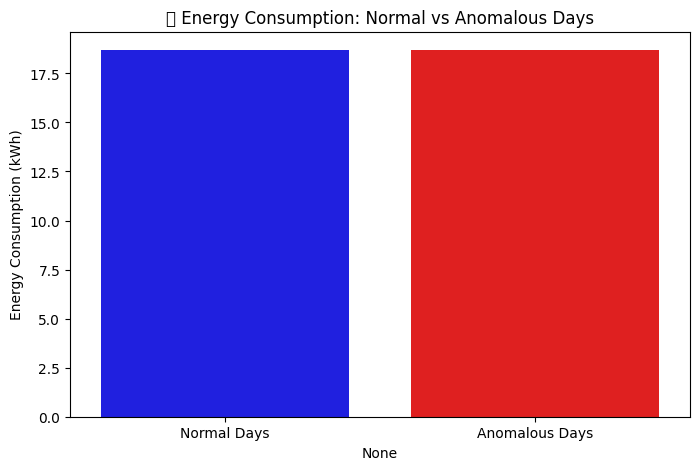

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load Merged Forecasted Data
merged_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/final_merged_data.csv"
df_merged = pd.read_csv(merged_data_path, parse_dates=["ds"])

# ✅ Separate Normal vs Anomalous Days
df_anomalous = df_merged[df_merged["validated_anomaly"] == True]
df_normal = df_merged[df_merged["validated_anomaly"] == True]

# ✅ Compute Mean Consumption for Comparison
summary = pd.DataFrame({
    "Mean Consumption (kWh)": [df_normal["Total_Hourly_Consumption"].mean(), 
                                df_anomalous["Total_Hourly_Consumption"].mean()],
    "Standard Deviation": [df_normal["Total_Hourly_Consumption"].std(), 
                           df_anomalous["Total_Hourly_Consumption"].std()]
}, index=["Normal Days", "Anomalous Days"])

print("**Anomaly vs Normal Consumption Summary**:")
print(summary)

# ✅ Visualization: Energy Consumption on Normal vs Anomalous Days
plt.figure(figsize=(8, 5))
sns.barplot(x=summary.index, y=summary["Mean Consumption (kWh)"], palette=["blue", "red"])
plt.title("🔍 Energy Consumption: Normal vs Anomalous Days")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


In [33]:
# ✅ Load Weather Data
weather_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/merged_energy_weather_data.csv"
df_weather = pd.read_csv(weather_data_path, parse_dates=["DateTime"])

# ✅ Ensure Date Formats Match
df_merged["DateTime"] = pd.to_datetime(df_merged["DateTime"], errors="coerce")
df_weather["DateTime"] = pd.to_datetime(df_weather["DateTime"], errors="coerce")

# ✅ Drop duplicate column in weather dataset (if it exists)
if "Total_Hourly_Consumption" in df_weather.columns:
    df_weather = df_weather.drop(columns=["Total_Hourly_Consumption"])

# ✅ Merge Weather Data Properly
df_merged = df_merged.merge(df_weather, on="DateTime", how="left", suffixes=("", "_weather"))

# ✅ Save Merged Data
df_merged.to_csv("/Users/anurag/Documents/EnergyGPT/data/processed/final_merged_data.csv", index=False)

print("✅ Weather data successfully merged!")


✅ Weather data successfully merged!


✅ Normal Days Successfully Imported & Merged!


<Figure size 1000x500 with 0 Axes>

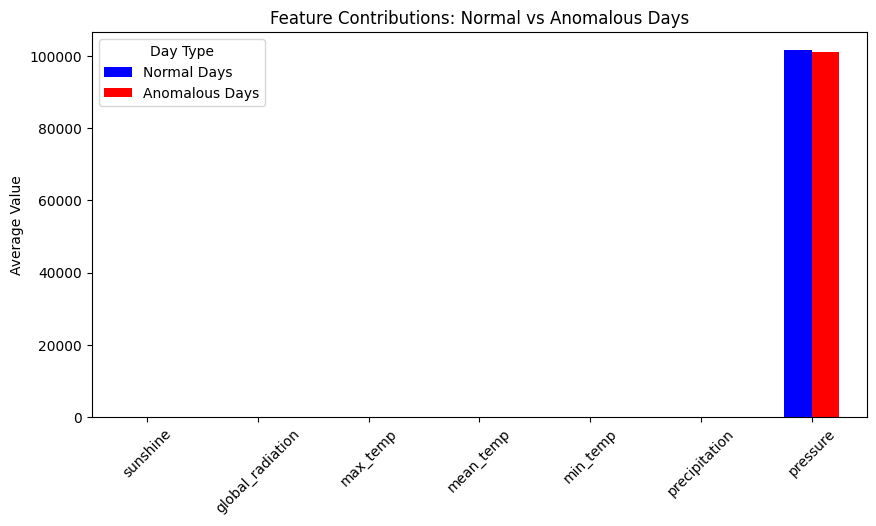


📊 Feature Contribution Analysis:
                     Normal Days  Anomalous Days
sunshine               4.349768          5.2500
global_radiation     118.754408        123.6250
max_temp              15.389130         14.7125
mean_temp             11.475910         10.7125
min_temp               7.560029          7.2500
precipitation          1.667345          4.1375
pressure          101536.826929     101112.5000


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Paths to Datasets
normal_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/clean_normal_data.csv"
merged_data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/final_merged_data.csv"

# ✅ Load Merged Data & Normal Days Data Separately
df_merged = pd.read_csv(merged_data_path, parse_dates=["DateTime"])
df_normal = pd.read_csv(normal_data_path, parse_dates=["DateTime"])

# ✅ Ensure "validated_anomaly" Column Exists
df_normal["validated_anomaly"] = False  # Assign all normal days as non-anomalous

# ✅ Merge Normal Days into the Main Dataset
df_combined = pd.concat([df_merged, df_normal], ignore_index=True)

# ✅ Save Updated Dataset
df_combined.to_csv("/Users/anurag/Documents/EnergyGPT/data/processed/final_combined_data.csv", index=False)

print("✅ Normal Days Successfully Imported & Merged!")

# 🔍 **Feature Contribution Analysis**
weather_features = ["sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure"]

# ✅ Compute Mean Values for Both Categories
summary = df_combined.groupby("validated_anomaly")[weather_features].mean().T
summary.columns = ["Normal Days", "Anomalous Days"]

# ✅ Plot Feature Contribution Comparison
plt.figure(figsize=(10, 5))
summary.plot(kind="bar", figsize=(10, 5), color=["blue", "red"])
plt.title("Feature Contributions: Normal vs Anomalous Days")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend(title="Day Type")
plt.show()

# ✅ Print Summary Table
print("\n📊 Feature Contribution Analysis:\n", summary)


/Users/anurag/Documents/EnergyGPT/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


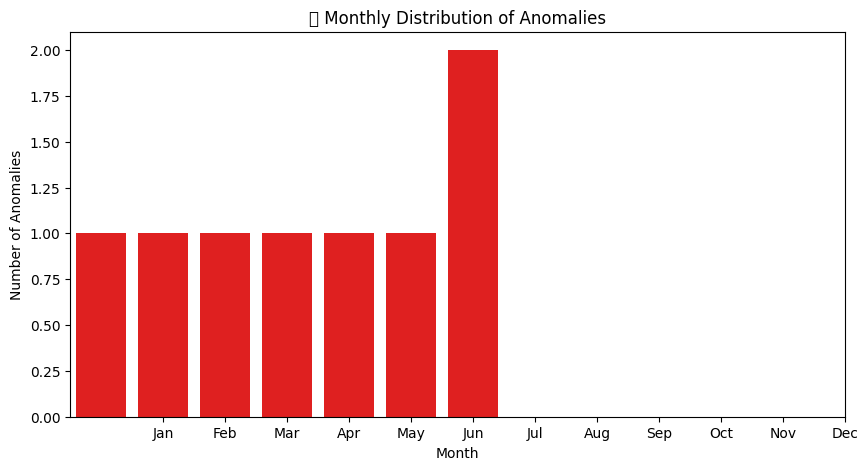

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load Merged Data
df_merged = pd.read_csv("/Users/anurag/Documents/EnergyGPT/data/processed/final_merged_data.csv", parse_dates=["DateTime"])

# ✅ Extract Month & Season for Analysis
df_merged["Month"] = df_merged["DateTime"].dt.month
df_merged["Season"] = df_merged["Month"].map({
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
})

# ✅ Count Anomalies by Month
monthly_anomalies = df_merged[df_merged["validated_anomaly"] == True]["Month"].value_counts().sort_index()

# ✅ Plot Monthly Anomalies
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_anomalies.index, y=monthly_anomalies.values, color="red")
plt.title("📊 Monthly Distribution of Anomalies")
plt.xlabel("Month")
plt.ylabel("Number of Anomalies")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()


📊 Model Performance:
✅ RMSE: 1.81 kWh
✅ R² Score: 0.4971


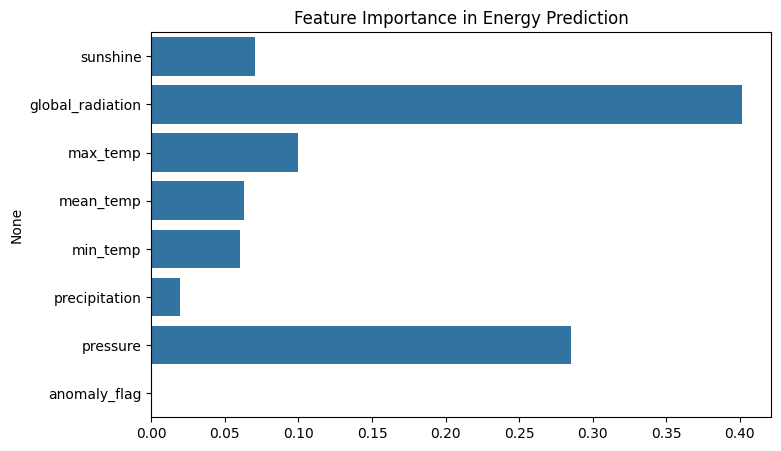

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ✅ Load Final Merged Dataset
data_path = "/Users/anurag/Documents/EnergyGPT/data/processed/final_merged_data.csv"
df = pd.read_csv(data_path, parse_dates=["DateTime"])

# ✅ Drop Missing Values (Ensure Clean Data)
df.dropna(inplace=True)

# ✅ Feature Selection (Weather + Anomaly Data)
features = ["sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure"]
df["anomaly_flag"] = df["validated_anomaly"].astype(int)  # Convert anomaly flag to numeric

X = df[features + ["anomaly_flag"]]
y = df["Total_Hourly_Consumption"]

# ✅ Train-Test Split (80-20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Predictions
y_pred = model.predict(X_test)

# ✅ Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Performance:")
print(f"✅ RMSE: {rmse:.2f} kWh")
print(f"✅ R² Score: {r2:.4f}")

# ✅ Feature Importance Plot
plt.figure(figsize=(8,5))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance in Energy Prediction")
plt.show()
